This notebook repeats and extends Sergey Koposov's procedure for creating a photometric distance calibration for main sequence stars

To do:<br>
Should we be using the g or r flux? g will have larger metallicity dependence, which makes it either better or worse than r for this purpose. <br>
More quality cuts on the measured stellar parameters?


In [8]:
import numpy as np
import pdb
from astropy.io import fits
import matplotlib.pylab as plt
import re
import os
import scipy
import scipy.stats as stats
import astropy.coordinates as coord
import astropy.units as u
#%autoreload 2

In [2]:
import astropy.table as atpy

In [3]:
datadir='/global/cfs/cdirs/desi/science/mws/redux/iron/rv_output/230211/'

Sergey's original work, repeated here

Read in data. This is the iron reductions with the MWS paramters.<br>
TG has the Gaia DR3 data

In [4]:
T = atpy.Table().read(datadir+'/rvtab-hpxcoadd-all.fits','RVTAB')
TG = atpy.Table().read(datadir+'/rvtab-hpxcoadd-all.fits', 'GAIA')
TF = atpy.Table().read(datadir+'/rvtab-hpxcoadd-all.fits', 'FIBERMAP')

In [5]:
# colours, fluxes corrected for extinction
# cmr has fixed ambiguity with fg0 vs fr0 from Segey's original notebook. 

gr = -2.5 * np.log10(TF['FLUX_G'] / TF['FLUX_R'])
gr0 = gr - 1.06 * TF['EBV']

fr0 = TF['FLUX_R'] * 10**(2.176 / 2.5 * TF['EBV'])
fg0 = TF['FLUX_G'] * 10**(3.237 / 2.5 * TF['EBV'])

/tmp/ipykernel_423262/1935530361.py:4: RuntimeWarning: divide by zero encountered in divide
  gr = -2.5 * np.log10(TF['FLUX_G'] / TF['FLUX_R'])
/tmp/ipykernel_423262/1935530361.py:4: RuntimeWarning: invalid value encountered in divide
  gr = -2.5 * np.log10(TF['FLUX_G'] / TF['FLUX_R'])
/tmp/ipykernel_423262/1935530361.py:4: RuntimeWarning: divide by zero encountered in log10
  gr = -2.5 * np.log10(TF['FLUX_G'] / TF['FLUX_R'])
/tmp/ipykernel_423262/1935530361.py:4: RuntimeWarning: invalid value encountered in log10
  gr = -2.5 * np.log10(TF['FLUX_G'] / TF['FLUX_R'])


Plot the plane we will use for this: g-r vs. [Fe/H]<br>
Weight by the ratio parallax/sqrt(flux)<br>
<br>
log10(flux) = log10(L/4piD^2)<br>
So in each g-r,[Fe/H] bin F * D^2 is constant<br>
Can simplify to sqrt(F)/plx constant in each bin. <br>
Both of those are measured quantities.<br>
Compute median values of per-bin calibration constant X = (plx/sqrt(F)) for each bin. <br>
Then for any star with flux F, distance estimate is 1/(sqrt(F) * X)

We will revisit these quality cuts later.

/tmp/ipykernel_423262/2334737057.py:3: RuntimeWarning: invalid value encountered in sqrt
  dstat,xedge,yedge,binnum = stats.binned_statistic_2d(T['FEH'][ind],gr0[ind],TG['PARALLAX'][ind]/np.sqrt(fr0[ind]),statistic='median',bins=[50,50],range=[[-4,1],[0.1,2]])


Text(0, 0.5, '[Fe/H]')

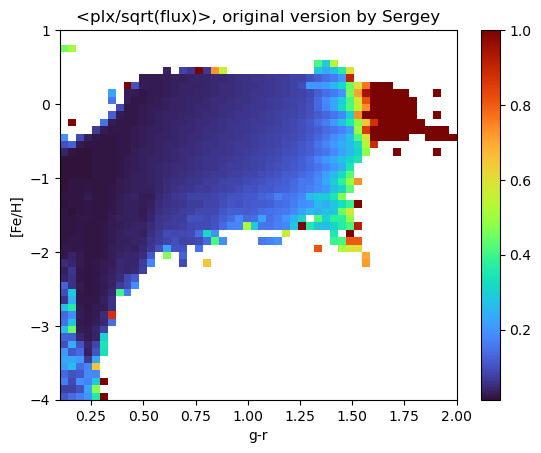

In [6]:
ind=(TF['FLUX_G']>0)&(TF['EBV']<.2)&(T['LOGG']>3)
# imshow puts the data in the 1st index on the vertical axis. hist2d histogarms the 1st argument along the axis indexed by the 1st index. So variable on the y axis for imshow is 1st arg for hist2d
dstat,xedge,yedge,binnum = stats.binned_statistic_2d(T['FEH'][ind],gr0[ind],TG['PARALLAX'][ind]/np.sqrt(fr0[ind]),statistic='median',bins=[50,50],range=[[-4,1],[0.1,2]])
plt.imshow(dstat,cmap='turbo',origin='lower',vmax=1,extent=[0.1,2,-4,1],aspect='auto')
plt.colorbar()
plt.title('<plx/sqrt(flux)>, original version by Sergey')
plt.xlabel('g-r')
plt.ylabel('[Fe/H]')


Sergey's original fit relation

In [9]:
xind = (TF['FLUX_G'] > 0) & (TF['EBV'] < .2) & (T['LOGG'] > 3) & (T['FEH']<1) & (T['FEH']>-4) & (TF['FLUX_R'] > 0)
nxbins = 51
nybins = 50
Sorig = scipy.stats.binned_statistic_2d(gr[xind],
                                    T['FEH'].quantity[xind],
                                    (TG['PARALLAX'] / np.sqrt(fr0))[xind],
                                    np.nanmedian,
                                    range=[[0.1, 2], [-4, 1]],
                                    bins=[nxbins, nybins])

x1 = np.searchsorted(Sorig.x_edge, gr0) - 1
x2 = np.searchsorted(Sorig.y_edge, T["FEH"]) - 1
xforig = Sorig.statistic[np.clip(x1, 0, nxbins - 1), np.clip(x2, 0, nybins - 1)]
xforig[x1 == nxbins] = np.nan
xforig[x2 == nybins] = np.nan
distorig = 1. / (np.sqrt(fr0) * xforig)

/tmp/ipykernel_423262/986595554.py:6: RuntimeWarning: invalid value encountered in sqrt
  (TG['PARALLAX'] / np.sqrt(fr0))[xind],
/global/common/software/nersc/pe/conda-envs/24.1.0/python-3.11/nersc-python/lib/python3.11/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: All-NaN slice encountered
  stat = stat_func(np.array(bin_map[i]))
/tmp/ipykernel_423262/986595554.py:16: RuntimeWarning: invalid value encountered in sqrt
  distorig = 1. / (np.sqrt(fr0) * xforig)
/tmp/ipykernel_423262/986595554.py:16: RuntimeWarning: divide by zero encountered in divide
  distorig = 1. / (np.sqrt(fr0) * xforig)


Look at results

Plot  absolute magnitude computed using parallax (best observed distance) as grayscale, and using the new g-r,[Fe/H] distance relation in red

/tmp/ipykernel_423262/2334670481.py:2: RuntimeWarning: divide by zero encountered in log10
  absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
/tmp/ipykernel_423262/2334670481.py:2: RuntimeWarning: invalid value encountered in log10
  absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
/tmp/ipykernel_423262/2334670481.py:5: RuntimeWarning: divide by zero encountered in log10
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distorig[ind] * 1e3) - 5)
/tmp/ipykernel_423262/2334670481.py:5: RuntimeWarning: invalid value encountered in log10
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distorig[ind] * 1e3) - 5)
/tmp/ipykernel_423262/2334670481.py:5: RuntimeWarning: invalid value encountered in subtract
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distorig[ind] * 1e3) - 5)


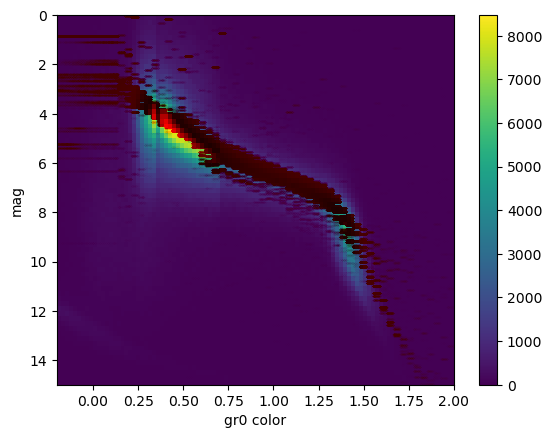

In [14]:
ind=TG['PARALLAX'] > 0
absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
tstat,xedge,yedge,bnum=stats.binned_statistic_2d(absmagplx,gr0[ind],gr0[ind],statistic='count',bins=[100,100],range=[[-5,15],[-0.2,2]])
plt.imshow(tstat,extent=[-0.2,2,15,-5],aspect='auto')
predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distorig[ind] * 1e3) - 5)
plt.plot(gr0[ind],predabsmag,'ro',ms=0.002)
plt.xlim(-0.2,2)
plt.xlabel('gr0 color')
plt.ylim(15,0)
plt.ylabel('abs mag')
plt.colorbar()


Does not look like the prediction from the new distance calibration matches the data.<br>
Playing around with vmax for imshow brings out different regions of the distribution in g-r.<br>
In the plot below, it seems the match is better in 0.6 < g-r < 1.3 (about), but still the prediction is not centered on the data. <br>

/tmp/ipykernel_423262/2597114409.py:2: RuntimeWarning: divide by zero encountered in log10
  absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
/tmp/ipykernel_423262/2597114409.py:2: RuntimeWarning: invalid value encountered in log10
  absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
/tmp/ipykernel_423262/2597114409.py:5: RuntimeWarning: divide by zero encountered in log10
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distorig[ind] * 1e3) - 5)
/tmp/ipykernel_423262/2597114409.py:5: RuntimeWarning: invalid value encountered in log10
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distorig[ind] * 1e3) - 5)
/tmp/ipykernel_423262/2597114409.py:5: RuntimeWarning: invalid value encountered in subtract
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distorig[ind] * 1e3) - 5)


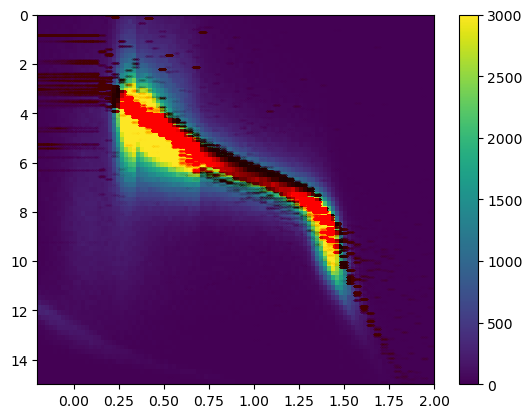

In [15]:
ind=TG['PARALLAX'] > 0
absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
tstat,xedge,yedge,bnum=stats.binned_statistic_2d(absmagplx,gr0[ind],gr0[ind],statistic='count',bins=[100,100],range=[[-5,15],[-0.2,2]])
plt.imshow(tstat,extent=[-0.2,2,15,-5],aspect='auto',vmax=3000)
predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distorig[ind] * 1e3) - 5)
plt.plot(gr0[ind],predabsmag,'ro',ms=0.002)
plt.xlim(-0.2,2)
plt.ylim(15,0)
plt.colorbar()

The bad mis-match in the blue suggests the problem is at larger distances. Bluer stars are more intrinsically luminous, so for a fixed apparent magnitude range will be at larger distances. <br>
There is also a lot of garbage at very blue g-r, < 0.1 because the calibration doesn't extend bluer than that. Should fix that eventually.

We know large parallax errors cause very biased distances, and we know the fractional parallax errors are larger at larger distances and fainter magnitudes. So try limiting the data we use for the calibration to only stars with "good" parallaxes, fractional error < 20%. The distance PDFs are not too badly skewed for those good parallaxes.

QA cuts now demand flux measurements in both r and r, < 20% parallax errors,as well as the limit on extinction and limits to just MS stars

First plot the sample. Same plot scaling as for the previous sample

Text(0, 0.5, '[Fe/H]')

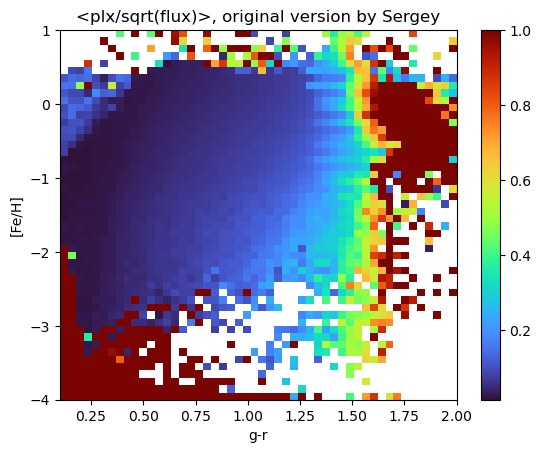

In [16]:
ind=(TF['FLUX_G']>0)&(TF['FLUX_R']>0)&(TF['EBV']<.2)&(T['LOGG']>3)&(TG['PARALLAX']/TG['PARALLAX_ERROR'] > 5)

# imshow puts the data in the 1st index on the vertical axis. hist2d histogarms the 1st argument along the axis indexed by the 1st index. So variable on the y axis for imshow is 1st arg for hist2d
dstat,xedge,yedge,binnum = stats.binned_statistic_2d(T['FEH'][ind],gr0[ind],TG['PARALLAX'][ind]/np.sqrt(fr0[ind]),statistic='median',bins=[50,50],range=[[-4,1],[0.1,2]])
plt.imshow(dstat,cmap='turbo',origin='lower',vmax=1,extent=[0.1,2,-4,1],aspect='auto')
plt.colorbar()
plt.title('<plx/sqrt(flux)>, original version by Sergey')
plt.xlabel('g-r')
plt.ylabel('[Fe/H]')

We want to make sure there are enough objects per bin to get a good estimate of the mean value of our statistic.<br>What do we have?<br>
I keep re-computing the selection index array, that is going to get me in troule at some point here...

Text(0.5, 1.0, 'cuts with parallax error < 20%')

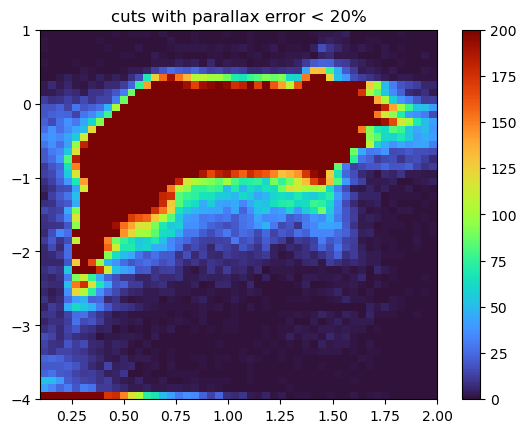

In [17]:
ind=(TF['FLUX_G']>0)&(TF['FLUX_R']>0)&(TF['EBV']<.2)&(T['LOGG']>3)&(TG['PARALLAX']/TG['PARALLAX_ERROR'] > 5)
a,b,c,d=plt.hist2d(gr[ind],T['FEH'][ind],range=[[0.1,2],[-4,1]],cmap='turbo',bins=[50,50],vmax=200)
plt.colorbar()
plt.title('cuts with parallax error < 20%')

Text(0.5, 1.0, 'cuts without constraint on parallax error')

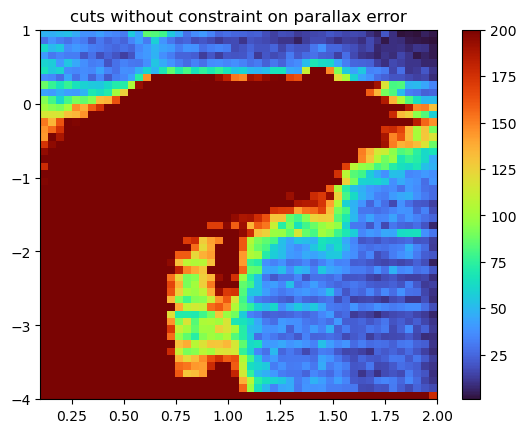

In [18]:
ind=(TF['FLUX_G']>0)&(TF['FLUX_R']>0)&(TF['EBV']<.2)&(T['LOGG']>3)
a,b,c,d=plt.hist2d(gr[ind],T['FEH'][ind],range=[[0.1,2],[-4,1]],cmap='turbo',bins=[50,50],vmax=200)
plt.colorbar()
plt.title('cuts without constraint on parallax error')

Unsurprisingly, it is metal poor stars at the MSTO, that are at the largest distances, that we mostly lose when using the parallax cut.<br><br>
There are other stars in the second plot that are not in the plot with the parallax cut (there is a obvious bunch at g-r ~ 1.0, [Fe/H] -2.25) which turn out to be star with no parallax measurements. Astropy tables are masked, and the mask is set for elements that don't have data. The mask is used in the boolean comparison for the condition in the QA selection, so those objects without parallax are also masked by the QA condition.  That's good, that's what we want.


Back to the original question: how many objects in each bin do we have to constrain this relationship for distance?<br>
See what a limit at 20 objects per bin looks like.<br>
Add recommended QA on the RVS parameters on RR_SPECTYPE and RVS_WARN

Text(0.5, 1.0, 'cuts with parallax error < 20%')

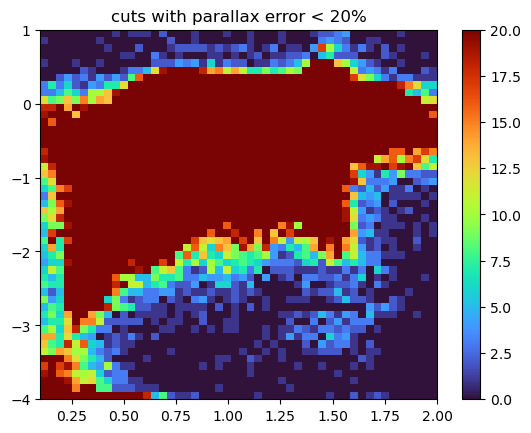

In [19]:
ind=(TF['FLUX_G']>0)&(TF['FLUX_R']>0)&(TF['EBV']<.2)&(T['LOGG']>3)&(TG['PARALLAX']/TG['PARALLAX_ERROR'] > 5)&(T['RVS_WARN']==0)&(T['RR_SPECTYPE']=='STAR')
a,b,c,d=plt.hist2d(gr[ind],T['FEH'][ind],range=[[0.1,2],[-4,1]],cmap='turbo',bins=[50,50],vmax=20)
plt.colorbar()
plt.title('cuts with parallax error < 20%')

OK, we will use that as a mask for the region on that plot where we have a valid distance calibration 

Now compute a "fixed" distance calibration

In [21]:
xind = (TG['PARALLAX']/TG['PARALLAX_ERROR'] > 5) &(fg0 > 0) & (fr0 > 0) & (TF['EBV'] < .2) & (T['LOGG'] > 3) &(T['FEH']<1) & (T['FEH']>-4) &(T['RVS_WARN']==0)&(T['RR_SPECTYPE']=='STAR')
nxbins = 51
nybins = 50
rangearr=[[0.1, 2], [-4, 1]]
binsarr = [nxbins, nybins]
Sfix = scipy.stats.binned_statistic_2d(gr0[xind],
                                    T['FEH'].quantity[xind],
                                    (TG['PARALLAX'] / np.sqrt(fr0))[xind],
                                    np.nanmedian,
                                    range=rangearr,
                                    bins=binsarr)

# make the 2d mask array
ct2darr = scipy.stats.binned_statistic_2d(gr0[xind],T['FEH'].quantity[xind],gr0[xind],'count',range=rangearr,bins=binsarr)
nmaskarr = ct2darr.statistic < 20

# mask the Sfix array
statarr = np.ma.array(Sfix.statistic, mask=nmaskarr)

x1 = np.searchsorted(Sfix.x_edge, gr0) - 1
x2 = np.searchsorted(Sfix.y_edge, T["FEH"]) - 1
xffix = statarr[np.clip(x1, 0, nxbins - 1), np.clip(x2, 0, nybins - 1)]
xffix[x1 == nxbins] = np.nan
xffix[x2 == nybins] = np.nan

# compute new distance estimates
distfix = 1. / (np.sqrt(fr0) * xffix)

/tmp/ipykernel_423262/911861303.py:8: RuntimeWarning: invalid value encountered in sqrt
  (TG['PARALLAX'] / np.sqrt(fr0))[xind],
/tmp/ipykernel_423262/911861303.py:27: RuntimeWarning: invalid value encountered in sqrt
  distfix = 1. / (np.sqrt(fr0) * xffix)


First make exactly the same test plot as before but with the new distances. We are comparing to the entire dataset, without any quality cuts (except the parallax>0 so we can estimate an absolute magnitude). So the problem in the earlier plots was not bias in the computed absolute magnitudes for hte comparison, but a bias in the calibration. 

/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/2467983439.py:2: RuntimeWarning: divide by zero encountered in log10
  absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/2467983439.py:2: RuntimeWarning: invalid value encountered in log10
  absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/2467983439.py:5: RuntimeWarning: divide by zero encountered in log10
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distfix[ind] * 1e3) - 5)
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/2467983439.py:5: RuntimeWarning: invalid value encountered in log10
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distfix[ind] * 1e3) - 5)


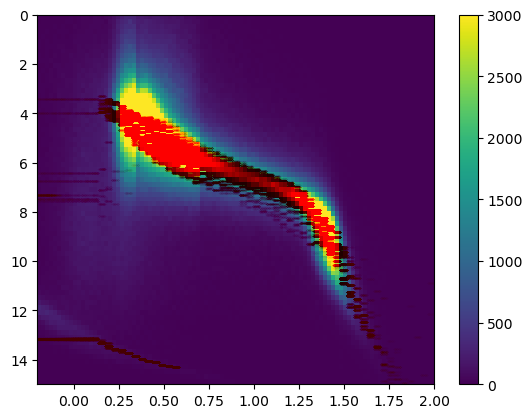

In [95]:
ind=TG['PARALLAX'] > 0
absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
tstat,xedge,yedge,bnum=stats.binned_statistic_2d(absmagplx,gr0[ind],gr0[ind],statistic='count',bins=[100,100],range=[[-5,15],[-0.2,2]])
plt.imshow(tstat,extent=[-0.2,2,15,-5],aspect='auto',vmax=3000)
predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distfix[ind] * 1e3) - 5)
plt.plot(gr0[ind],predabsmag,'ro',ms=0.002)
plt.xlim(-0.2,2)
plt.ylim(15,0)
plt.colorbar()

Much better. <br>
We still have junk at large abs mag and in the blue.

What makes the "fringe" of stars at larger absolute magnitude?<br>
Plot color-coded by [Fe/H], and can see those are more metal-poor stars, which is as expected.

/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/3094937960.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(gr0[ind],22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distfix[ind] * 1e3) - 5),c=T['FEH'][ind],s=0.002,vmin=-3)
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/3094937960.py:2: RuntimeWarning: invalid value encountered in log10
  plt.scatter(gr0[ind],22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distfix[ind] * 1e3) - 5),c=T['FEH'][ind],s=0.002,vmin=-3)


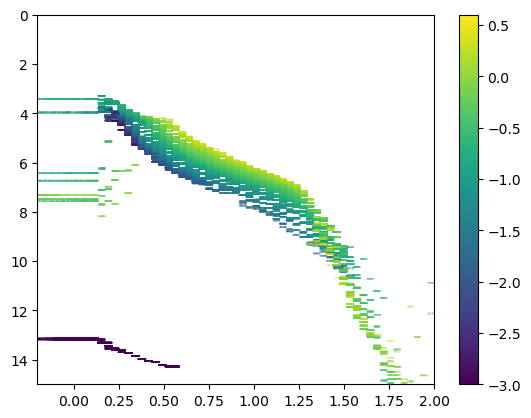

In [96]:
ind=TG['PARALLAX'] > 0
plt.scatter(gr0[ind],22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distfix[ind] * 1e3) - 5),c=T['FEH'][ind],s=0.002,vmin=-3)
plt.xlim(-0.2,2)
plt.ylim(15,0)
plt.colorbar()

Now test on cluster and dwarf galaxy data, where we have lots of stars over a range in g-r with known [Fe/H] and at known distances.

These are the clusters from the Cooper et al. DESI MWS overview paper. Should add Draco dSph and any additional clusters or dSph (Sextans? UMi?)

In [97]:
# test on M5
# data from Harris and Vasielev 2019
m5rking = (10**1.73)*0.44
m5ra=(15*(15+18/60.+33.2/3600))
m5dec=(2+4/60.+51.7/3600)
m5rad = m5rking/60
print(m5ra)
print(m5dec)
print(m5rad)
m5pmra=4.078
m5pmdec=-9.854
m5rv=53.2
m5rvdisp=5.5

229.63833333333335
2.081027777777778
0.3938233173381853


In [98]:
m53ra=(15*(13+12/60.+55.25/3600))
m53dec=(18+10/60.+5.4/3600)
m53rking = (10**1.72)*0.35
m53rad = m53rking/60
print(m53ra)
print(m53dec)
print(m53rad)
m53pmra=-0.148
m53pmdec=-1.355
m53rv=-62.9
m53rvdisp=4.4

198.23020833333334
18.168166666666668
0.30613768514570067


In [99]:
n5053ra=(15*(13+16/60.+27.09/3600))
n5053dec=(17+42/60.+1/3600)
n5053rking=(10**0.74)*2.08
n5053rad=n5053rking/60
n5053rv=44.0
n5053rvdisp=1.4
n5053pmra=-0.366
n5053pmdec=-1.248
print(n5053ra)
print(n5053dec)
print(n5053rad)

199.112875
17.700277777777778
0.19050750293730986


In [100]:
m44ra=(15*(8+40/60.+13/3600))
m44dec=(19+37/60.+16/3600)
# m44 not in Harris. Found a reference that has the tidal radius = 3x the halflight radius
m44rking=3*118
m44rad=m44rking/60
m44pmra=-36.09
m44pmdec=-12.919
m44rv=34.53
m44rvdisp=1.0
print(m44ra)
print(m44dec)
print(m44rad)

130.05416666666665
19.621111111111112
5.9


In [101]:
m92ra=(15*(17+17/60.+7.39/3600))
m92dec=(43+8/60.+9.4/3600)
m92rking = (10**1.68)*0.26
m92rad = m92rking/60
print(m92ra)
print(m92dec)
print(m92rad)
m92pmra=-4.925
m92pmdec=-0.536
m92rv=-120
m92rvdisp=6.0

259.2807916666667
43.13594444444444
0.20740637333980994


In [102]:
m13ra=(15*(16+41/60+41.24/3600))
m13dec=(36+27/60.+35.5/3600)
m13rking = (10**1.53)*0.62
m13rad = m13rking/60
print(m13ra)
print(m13dec)
print(m13rad)
m13pmra=-3.164
m13pmdec=-2.588
m13rv=-244
m13rvdisp=7.1

250.42183333333335
36.45986111111112
0.35013896134384265


In [103]:
n2419ra=(15*(7+38/60.+8.47/3600))
n2419dec=(38+52/60.+56.8/3600)
n2419rking=(10**1.37)*0.32
n2419rad=n2419rking/60
n2419rv=-20.2
n2419rvdisp=4.0
n2419pmra=-0.011
n2419pmdec=-0.557
print(n2419ra)
print(n2419dec)
print(n2419rad)

114.53529166666665
38.882444444444445
0.12502553681706255


In [104]:
dracora=260.05
dracodec=57.915
dracorad=0.3
dracorv=-293.8
dracorvdisp=10.5
dracopmra=0.045
dracopmdec=-0.188
dracodistmod=19.53 #dist 76 kpc

In [105]:
class objdata:
    
    def __init__(self,rvtabdat,sptabdat,fibdat,gaiadat):
        self.rvtab=rvtabdat
        self.sptab=sptabdat
        self.fibermap=fibdat
        self.gaia=gaiadat
    def addmags(self,gmag,rmag,zmag):
        self.gmag = gmag
        self.rmag = rmag
        self.zmag = zmag
        self.gmr=gmag-rmag
        self.rmz=rmag-zmag  
    # add the astropy sky coordindate of the center used to select the sample
    # up to you to maintain consistency
    def addcen(self,centercoords):
        self.cencoord=centercoords
    def addqa(self,rvtabdat):
        mask= (rvtabdat['RVS_WARN'] == 0) & (rvtabdat['RR_SPECTYPE'] == 'STAR')&(rvtabdat['VSINI']<50)
        self.qa = mask
    def addselmask(self,selmask):  # selection mask if picking members out of a larger dataset
        self.selmask = selmask

In [108]:
# use PM, ra,dec location and RV to get spectra taken of a cluster, dwarf galaxy, etc
# ra0,dec0 and selrad in degrees. pmdata assumed to be gaiadr3. any parameter 
# excepet ra0,dec0 and selrad can be None
# datafile assumes the fuji EDR VAC format
# that also works for Iron data if we leave out the ferre/sp tables which we don't have
def getobjsamp(rvt,gaiat,fst,ra0,dec0,selrad,pmra0,pmdec0,rv0,rvselrange,addmags=True,addcen=True,minpmdisp=1.0,dospt=True,addqa=True,addselmask=False):
    import numpy as np
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    
    # these from an older version that read directly from disk
    #ahdul=fits.open(datafile)
    #rvt=ahdul['rvtab'].data
    #spt=ahdul['sptab'].data
    #fst=ahdul['FIBERMAP'].data
    #gaiat=ahdul['GAIA'].data
    #scoret=ahdul['SCORES'].data
    ravec=rvt['TARGET_RA']
    decvec=rvt['TARGET_DEC']
    pmravec=gaiat['PMRA']
    pmdecvec=gaiat['PMDEC']
    pmraerrvec=gaiat['PMRA_ERROR']
    pmdecerrvec=gaiat['PMDEC_ERROR']
    #pmvec = np.sqrt(pmravec**2+pmdec**2)
    rvvec=rvt['VRAD']
    rverrvec=rvt['VRAD_ERR']
    
    
    cenc=SkyCoord(ra=ra0*u.degree, dec=dec0*u.degree,frame='icrs')
    datac=SkyCoord(ra=ravec*u.degree, dec=decvec*u.degree,frame='icrs')
    distv=cenc.separation(datac)
    selmask=(distv.value<selrad)
    if pmra0 is not None:
        selmask = selmask & (np.abs(pmravec - pmra0) < np.maximum(minpmdisp,3*pmraerrvec))&(np.abs(pmdecvec - pmdec0) < np.maximum(minpmdisp,3*pmdecerrvec))
    if rv0 is not None:
        selmask = selmask & (np.abs(rvvec - rv0) < np.maximum(3*rvselrange,3*rverrvec))
    
    if dospt == True:
        spt=ahdul['sptab'].data
        sptobj=spt[selmask==True]
    else:
        sptobj=None
    
    rvtobj=rvt[selmask==True]
    fstobj=fst[selmask==True]
    objsamp=objdata(rvtobj,sptobj,fstobj,gaiat[selmask==True])
      
    if addmags==True:
        gmag=-2.5*np.log10(fstobj['FLUX_G'])+22.5
        rmag=-2.5*np.log10(fstobj['FLUX_R'])+22.5
        zmag=-2.5*np.log10(fstobj['FLUX_Z'])+22.5
        objsamp.addmags(gmag,rmag,zmag)
    if addcen==True:
        objsamp.addcen(cenc)
    if addqa==True:
        objsamp.addqa(rvtobj)
    if addselmask == True:
        objsamp.addselmask(selmask)
    return objsamp

In [109]:
m5dat=getobjsamp(T,TG,TF,m5ra,m5dec,m5rad,m5pmra,m5pmdec,m5rv,m5rvdisp,dospt=False,addselmask=True)
m53dat=getobjsamp(T,TG,TF,m53ra,m53dec,m53rad,m53pmra,m53pmdec,m53rv,m53rvdisp,dospt=False,addselmask=True)
n5053dat=getobjsamp(T,TG,TF,n5053ra,n5053dec,n5053rad,n5053pmra,n5053pmdec,n5053rv,n5053rvdisp,dospt=False,addselmask=True)
m13dat=getobjsamp(T,TG,TF,m13ra,m13dec,m13rad,m13pmra,m13pmdec,m13rv,m13rvdisp,dospt=False,addselmask=True)
m44dat=getobjsamp(T,TG,TF,m44ra,m44dec,m44rad,m44pmra,m44pmdec,m44rv,m44rvdisp,dospt=False,addselmask=True)
m92dat=getobjsamp(T,TG,TF,m92ra,m92dec,m92rad,m92pmra,m92pmdec,m92rv,m92rvdisp,dospt=False,addselmask=True)
n2419dat=getobjsamp(T,TG,TF,n2419ra,n2419dec,n2419rad,n2419pmra,n2419pmdec,n2419rv,n2419rvdisp,dospt=False,addselmask=True)
dracodat=getobjsamp(T,TG,TF,dracora,dracodec,dracorad,dracopmra,dracopmdec,dracorv,dracorvdisp,dospt=False,addselmask=True)

/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1977110109.py:49: RuntimeWarning: divide by zero encountered in log10
  gmag=-2.5*np.log10(fstobj['FLUX_G'])+22.5
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1977110109.py:49: RuntimeWarning: invalid value encountered in log10
  gmag=-2.5*np.log10(fstobj['FLUX_G'])+22.5
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1977110109.py:50: RuntimeWarning: divide by zero encountered in log10
  rmag=-2.5*np.log10(fstobj['FLUX_R'])+22.5
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1977110109.py:50: RuntimeWarning: invalid value encountered in log10
  rmag=-2.5*np.log10(fstobj['FLUX_R'])+22.5
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1977110109.py:51: RuntimeWarning: divide by zero encountered in log10
  zmag=-2.5*np.log10(fstobj['FLUX_Z'])+22.5
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1977110109.py:51: RuntimeWarning: invalid 

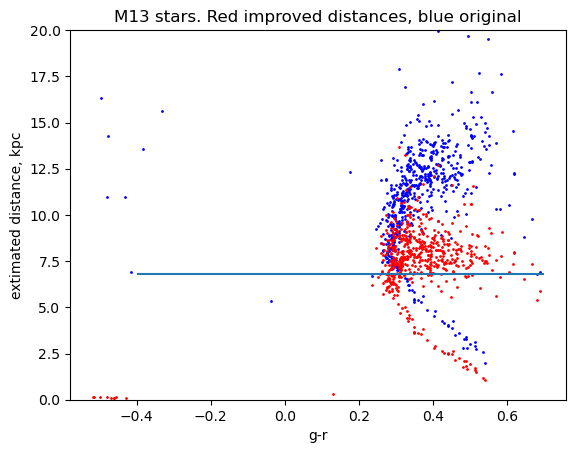

In [117]:
idx=np.where(m13dat.rvtab['LOGG']>3)[0]
plt.plot(m13dat.gmr[idx],distorig[m13dat.selmask][idx],'bo',ms=1)
plt.plot(m13dat.gmr[idx],distfix[m13dat.selmask][idx],'ro',ms=1)
plt.xlabel('g-r')
plt.ylabel('extimated distance, kpc')
plt.title('M13 stars. Red improved distances, blue original')
plt.ylim(0,20)
plt.hlines(6.8,-0.4,0.7)

Eeeew. <br>
The good news is that the new distances are better. 

What stars are those with such small distances?

Text(0.5, 1.0, 'M13 stars, color-coded by estimated log(g)')

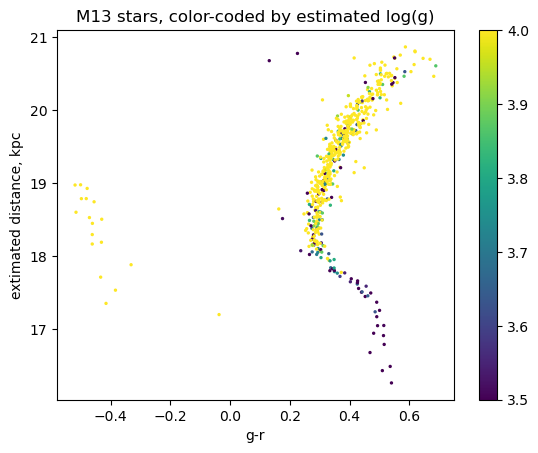

In [118]:
plt.scatter(m13dat.gmr,m13dat.rmag,c=m13dat.rvtab['LOGG'],vmin=3.5,vmax=4,s=2)
plt.colorbar()
plt.xlabel('g-r')
plt.ylabel('extimated distance, kpc')
plt.title('M13 stars, color-coded by estimated log(g)')

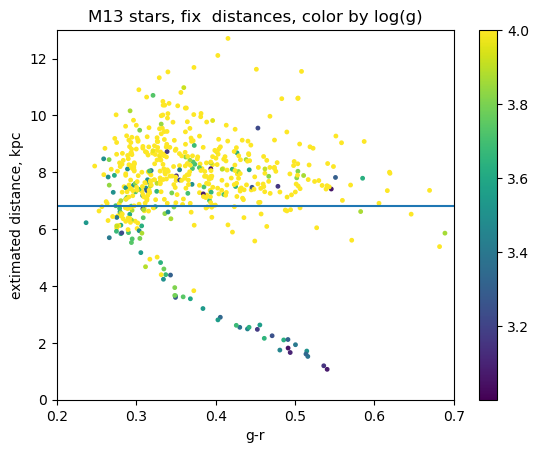

In [126]:
idx=np.where(m13dat.rvtab['LOGG']>3)[0]
plt.scatter(m13dat.gmr[idx],distfix[m13dat.selmask][idx],c=m13dat.rvtab['LOGG'][idx],s=6,vmax=4)
plt.colorbar()
plt.xlabel('g-r')
plt.ylabel('extimated distance, kpc')
plt.title('M13 stars, fix  distances, color by log(g)')
plt.ylim(0,13)
plt.xlim(0.2,0.7)
plt.hlines(6.8,-0.4,0.7)

Need a much more restrictive cut in log(g), pretty close to 4. We will lose some MS stars, but I don't see a way around that. Try 4 for now, there is probably a way to otimize. And should check if it depends on [Fe/H]

7.858032756285634
11.886638512987174


Text(0, 0.5, 'M13 distance estimate, kpc')

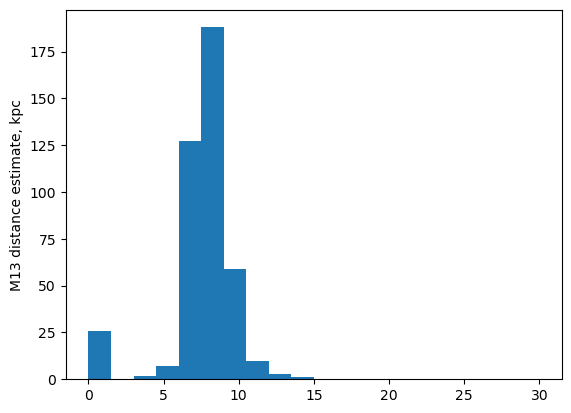

In [140]:
idx=np.where(m13dat.rvtab['LOGG']>4)[0]
a,b,c=plt.hist(distfix[m13dat.selmask][idx],range=[0,30],bins=20)
print(np.nanmedian(distfix[m13dat.selmask][idx]))
print(np.nanmedian(distorig[m13dat.selmask][idx]))
plt.ylabel('M13 distance estimate, kpc')

Much better, though not right yet.  Median distance 7.8 kpc is still not a match to the true value of 6.8 kpc, but better than the original estimates.  And this is for all stars logg > 4 only, so the logg cut was not the only problem with the old distances. <br>
Those stars near 0 are the blue BHBs (see earlier plot of distance vs. g-r)

Revise calbration one more time, with the cut at logg > 4.<br>
Also, mask regions of g-r,[Fe/H] where there is no calibration.

In [129]:
xind = (TG['PARALLAX']/TG['PARALLAX_ERROR'] > 5) & (fg0 > 0) & (TF['EBV'] < .2) & (T['LOGG'] > 4) & (T['FEH']<1) & (T['FEH']>-4) & (fr0 > 0)&(T['RVS_WARN']==0)&(T['RR_SPECTYPE']=='STAR')
nxbins = 51
nybins = 50
rangearr=[[0.1, 2], [-4, 1]]
binsarr = [nxbins, nybins]
Sfix2 = scipy.stats.binned_statistic_2d(gr0[xind],
                                    T['FEH'].quantity[xind],
                                    (TG['PARALLAX'] / np.sqrt(fr0))[xind],
                                    np.nanmedian,
                                    range=rangearr,
                                    bins=binsarr)

# mask to remove bins in g-r,[Fe/H] with too few stars
ct2darr = scipy.stats.binned_statistic_2d(gr0[xind],T['FEH'].quantity[xind],gr0[xind],'count',range=rangearr,bins=binsarr)
# remember,select the objects you want to mask, so mask == True
nmaskarr = ct2darr.statistic < 20
statarr2 = np.ma.array(Sfix2.statistic, mask=nmaskarr)

x1 = np.searchsorted(Sfix2.x_edge, gr0) - 1
x2 = np.searchsorted(Sfix2.y_edge, T["FEH"]) - 1
xffix2 = statarr2[np.clip(x1, 0, nxbins - 1), np.clip(x2, 0, nybins - 1)]
xffix2[x1 == nxbins] = np.nan
xffix2[x2 == nybins] = np.nan

#need to mask invalid parameters here. The masking in FeH,g-r makes sure we don't assign a distance estimate to stars were we don't have data to calibrate the relation
# remember,select the objects you want to mask, so mask == True
# This should include masking stars outside the g-r and [Fe/H] limits of the calibration. Right now we only mask
# bins with low counts inside the calibration region.
dind = ~((fg0 > 0) & (TF['EBV'] < .2) & (T['LOGG'] > 4) & (T['FEH']<1) & (T['FEH']>-4) & (fr0 > 0)&(T['RVS_WARN']==0)&(T['RR_SPECTYPE']=='STAR'))
maxffix2=np.ma.array(xffix2,mask=dind)
distfix2 = 1. / (np.sqrt(fr0) * maxffix2)

/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/3267221396.py:8: RuntimeWarning: invalid value encountered in sqrt
  (TG['PARALLAX'] / np.sqrt(fr0))[xind],
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/3267221396.py:31: RuntimeWarning: invalid value encountered in sqrt
  distfix2 = 1. / (np.sqrt(fr0) * maxffix2)


/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1826887503.py:2: RuntimeWarning: divide by zero encountered in log10
  absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1826887503.py:2: RuntimeWarning: invalid value encountered in log10
  absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1826887503.py:5: RuntimeWarning: divide by zero encountered in log10
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distfix2[ind] * 1e3) - 5)
/var/folders/c1/96nd_8m96j1gj0z8l34tsx1c0000gn/T/ipykernel_13804/1826887503.py:5: RuntimeWarning: invalid value encountered in log10
  predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distfix2[ind] * 1e3) - 5)


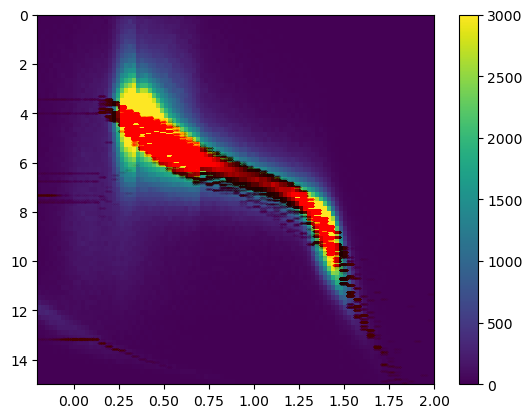

In [131]:
ind=TG['PARALLAX'] > 0
absmagplx = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(1e3 / TG['PARALLAX'][ind]) - 5)
tstat,xedge,yedge,bnum=stats.binned_statistic_2d(absmagplx,gr0[ind],gr0[ind],statistic='count',bins=[100,100],range=[[-5,15],[-0.2,2]])
plt.imshow(tstat,extent=[-0.2,2,15,-5],aspect='auto',vmax=3000)
predabsmag = 22.5 - 2.5 * np.log10(fr0[ind]) - (5 * np.log10(distfix2[ind] * 1e3) - 5)
plt.plot(gr0[ind],predabsmag,'ro',ms=0.002)
plt.xlim(-0.2,2)
plt.ylim(15,0)
plt.colorbar()

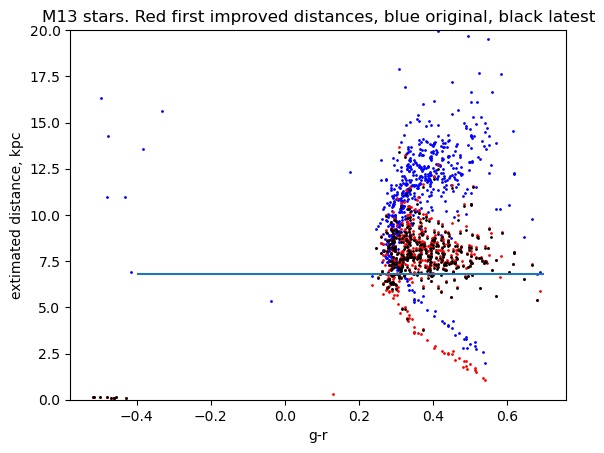

In [133]:
idx=np.where(m13dat.rvtab['LOGG']>3)[0]
plt.plot(m13dat.gmr[idx],distorig[m13dat.selmask][idx],'bo',ms=1)
plt.plot(m13dat.gmr[idx],distfix[m13dat.selmask][idx],'ro',ms=1)
plt.plot(m13dat.gmr[idx],distfix2[m13dat.selmask][idx],'ko',ms=1)
plt.xlabel('g-r')
plt.ylabel('extimated distance, kpc')
plt.title('M13 stars. Red first improved distances, blue original, black latest')
plt.ylim(0,20)
plt.hlines(6.8,-0.4,0.7)

7.171583944358141


Text(0, 0.5, 'M13 distance estimate, kpc')

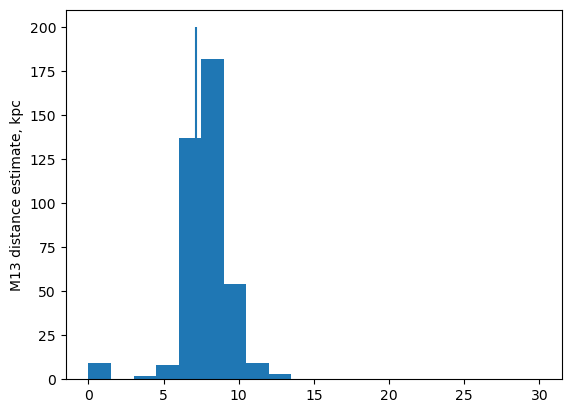

In [139]:
#matplotlib histogram does not use masks
a,b,c=plt.hist(distfix2[m13dat.selmask][~distfix2[m13dat.selmask].mask],range=[0,30],bins=20)
print(np.median(distfix2[m13dat.selmask]))
plt.vlines(np.median(distfix2[m13dat.selmask]),0,200)
plt.ylabel('M13 distance estimate, kpc')

Now we're talking -- that's getting pretty close.  <br>
How does this do for other clusters, Draco, etc?